In [16]:
from dotenv import load_dotenv

load_dotenv()

True

In [17]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
    max_results=3,
    search_depth="basic",
    include_answer=True,
    include_raw_content=True,
    include_images=False,
    # include_domains=["n.news.naver.com"],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    #description="search action을 수행합니다.",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)
    # 기업의 주요 사업부와 그와 관련된 뉴스를 확인합니다.
    # 사업부별 매출처와 관련된 시장 전망 뉴스를 수집합니다.
    # 사업부별 매출처와 관련된 기업의 경쟁 상황 관련 뉴스를 확인합니다.
    # 사업부별 매출처와 관련된 기업의 성장 가능성 관련 뉴스를 확인합니다.
    # 사업부별 매출처와 관련된 기업의 위험 요소 관련 뉴스를 확인합니다.

In [18]:
from langchain_community.tools import DuckDuckGoSearchResults

duckduckgo_search_tool = DuckDuckGoSearchResults(backend="news")

In [19]:
from langchain_core.tools import tool
import yfinance as yf
from yahooquery import search
from deep_translator import GoogleTranslator

# 한글 문자 범위를 이용해 한글 포함 여부 확인
def contains_korean(text):
    for char in text:
        if '\uac00' <= char <= '\ud7a3' or '\u3131' <= char <= '\u318e':
            return True
    return False

def get_ticker(company_name):
    try:            
        # 한글 포함 여부 확인
        is_korean = contains_korean(company_name)
        if is_korean:
            # 회사명을 영어로 번역
            translated = GoogleTranslator(source='auto', target='en').translate(company_name)
            
            # 번역된 이름으로 검색
            results = search(translated)
        else:
            results = search(company_name)
            
        # KSC, NYSE, NASDAQ, AMEX, JPX, HKG 순서로 찾기
        for quote in results['quotes']:
            if quote['exchange'] == 'KSC': # 한국
                return quote['symbol']
            elif quote['exchange'] == 'NYQ': # NYSE
                return quote['symbol']
            elif quote['exchange'] == 'NMS': # NASDAQ
                return quote['symbol']
            elif quote['exchange'] == 'JPX': # 일본
                return quote['symbol']
            elif quote['exchange'] == 'HKG': # 홍콩
                return quote['symbol']
            else:
                continue
        
        # KSC, NYSE, NASDAQ, AMEX에 없으면 None 반환
        return None
    except Exception as e:
        print(f"Error translating or searching for {company_name}: {e}")
        return None

@tool
def find_price_tool(company: str) -> str:
    """기업의 어제 종가를 찾습니다."""
    ticker = get_ticker(company)
    if ticker is None:
        return None 
    else:
        ticker = yf.Ticker(ticker)
        last_price = ticker.info["regularMarketPreviousClose"]
        return {"어제 종가":last_price}
    
@tool
def find_PER_tool(company: str) -> str:
    """기업의 현재 PER(TTM)를 찾습니다."""
    ticker = get_ticker(company)
    if ticker is None:
        return None
    else:
        ticker = yf.Ticker(ticker)
        earning_ttm = 0
        for i in range(4):
            earning_ttm += ticker.quarterly_income_stmt.loc['Net Income Common Stockholders'][i]
        trailingPERttm = ticker.info["marketCap"]/earning_ttm
        return {"PER":trailingPERttm}
    
@tool
def find_PBR_tool(company: str) -> str:
    """기업의 현재 PBR(최근 분기 기준)를 찾습니다."""
    ticker = get_ticker(company)
    if ticker is None:
        return None
    else:
        ticker = yf.Ticker(ticker)
        equity = ticker.quarterly_balance_sheet.loc['Stockholders Equity'][0]
        market_cap=ticker.info["marketCap"]
        PBR = market_cap/equity
        return {"PBR":PBR}
    
@tool
def find_EPS_tool(company: str) -> str:
    """기업의 현재 EPS(TTM)을 확인하고 계산합니다."""
    ticker = get_ticker(company)
    if ticker is None:
        return None
    else:
        ticker = yf.Ticker(ticker)
        earning_ttm = 0
        for i in range(4):
            earning_ttm += ticker.quarterly_income_stmt.loc['Net Income Common Stockholders'][i]
        EPSttm = earning_ttm/ticker.info["sharesOutstanding"]
        return {"EPS":EPSttm}

@tool
def find_BPS_tool(company: str) -> str:
    """기업의 현재 BPS(최근 분기 기준)을 확인하고 계산합니다."""
    ticker = get_ticker(company)
    if ticker is None:
        return None
    else:
        ticker = yf.Ticker(ticker)
        equity = ticker.quarterly_balance_sheet.loc['Stockholders Equity'][0]
        BPS = equity/ticker.info["sharesOutstanding"]
        return {"BPS":BPS}


In [20]:
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic
llm_openai = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_claude = ChatAnthropic(model="claude-3-5-haiku-20241022", temperature=0)
llm = llm_openai

In [21]:
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_core.prompts import PromptTemplate

response_schemas = [
    ResponseSchema(name="answer", description="사용자의 질문에 대한 답변, 파이썬 리스트 형식이어야 함."),
    ]

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
# 출력 형식 지시사항을 파싱합니다.
format_instructions = output_parser.get_format_instructions()
prompt = PromptTemplate(
    # 사용자의 질문에 최대한 답변하도록 템플릿을 설정합니다.
    template="answer the users question as best as possible.\n{format_instructions}\n{question}",
    # 입력 변수로 'question'을 사용합니다.
    input_variables=["question"],
    # 부분 변수로 'format_instructions'을 사용합니다.
    partial_variables={"format_instructions": format_instructions},
)

In [22]:
def find_peer(company: str) -> list[str]:
    prompt = PromptTemplate(
    # 사용자의 질문에 최대한 답변하도록 템플릿을 설정합니다.
    template="answer the users question as best as possible.\n{format_instructions}\n{question}",
    # 입력 변수로 'question'을 사용합니다.
    input_variables=["question"],
    # 부분 변수로 'format_instructions'을 사용합니다.
    partial_variables={"format_instructions": format_instructions},
    )
    chain = prompt | llm | output_parser  # 프롬프트, 모델, 출력 파서를 연결
    peer_list = chain.invoke({"question": f"{company}와 사업구조가 비슷하고, 같은 산업 혹은 섹터에 속한 경쟁사는?"
                              "(코스피, 뉴욕거래소 등 상장된 회사만 찾으세요. 반드시 회사명만 출력해주세요.)"})
    return peer_list


@tool
def find_peer_PERs_tool(company: str):
    """기업과 동종 업계의 Peer Group PER 평균을 찾습니다."""
    ticker = get_ticker(company)
    peer_list = find_peer(company)['answer']
    if ticker is None:
        return None
    
    peer_pers = {}
    for peer in peer_list:
        ticker = get_ticker(peer)
        if ticker is None:
            continue
        elif ".KS" in ticker:
            ticker = yf.Ticker(ticker)
            earning_ttm = 0
            for i in range(4):
                earning_ttm += ticker.quarterly_income_stmt.loc['Net Income Common Stockholders'][i]
            trailingPERttm = ticker.info.get("marketCap")/earning_ttm
            if trailingPERttm <0 :
                continue
            peer_pers[peer] = trailingPERttm
        else:
            ticker = yf.Ticker(ticker)
            earning_ttm = 0
            for i in range(4):
                earning_ttm += ticker.quarterly_income_stmt.loc['Net Income Common Stockholders'][i]
            trailingPERttm = ticker.info.get("marketCap")/earning_ttm*0.7 # 외국 주식의 경우 PER을 30% 할인
            if trailingPERttm <0 :
                continue
            peer_pers[peer] = trailingPERttm
    
    average_peer_per = sum(peer_pers.values()) / len(peer_pers)

    return {
        "Peer PERs": peer_pers,
        "Peer list": peer_list,
        "Average Peer PER": average_peer_per
    }

@tool
def find_peer_PBRs_tool(company: str):
    """기업과 동종 업계의 Peer Group PBR 평균을 찾습니다."""
    ticker = get_ticker(company)
    peer_list = find_peer(company)['answer']
    if ticker is None:
        return None
    
    peer_pbrs = {}
    for peer in peer_list:
        ticker = get_ticker(peer)
        if ticker is None:
            continue
        elif ".KS" in ticker:
            ticker = yf.Ticker(ticker)
            equity = ticker.quarterly_balance_sheet.loc['Stockholders Equity'][0]
            market_cap=ticker.info["marketCap"]
            PBR = market_cap/equity
            if PBR <0 :
                continue
            peer_pbrs[peer] = PBR
        else:
            ticker = yf.Ticker(ticker)
            equity = ticker.quarterly_balance_sheet.loc['Stockholders Equity'][0]
            market_cap=ticker.info["marketCap"]
            PBR = market_cap/equity*0.7 # 외국 주식의 경우 PBR을 30% 할인
            if PBR <0 :
                continue
            peer_pbrs[peer] = PBR
    
    average_peer_pbr = sum(peer_pbrs.values()) / len(peer_pbrs)

    return {
        "Peer PBRs": peer_pbrs,
        "Peer list": peer_list,
        "Average Peer PBR": average_peer_pbr
    }

In [23]:
from langgraph.prebuilt import create_react_agent
from datetime import datetime

today = datetime.now().strftime("%Y-%m-%d")
#TODO: PER로 계산한 결과가 뉴스로 찾은 근거와는 다르게 나오는 경우 PBR 계산으로 확인하도록 하거나, 처음부터 기업 상황을 체크해서 PER, PBR, EV/EBITDA 중 하나를 택하도록 하는 방법 있음.
prompt = f"""항상 {today}를 기준으로 확인 및 예상.
1. 현재 EPS(TTM)가 0보다 작은 경우 PBR 방식을 사용. 현재 EPS(TTM)가 0보다 큰 경우 PER 방식을 사용.
2. 기업의 매출을 책임지는 주요 사업부 리스트와 주요 사업부의 수익 창출 방법 설명 그리고 그 사업부의 매출 비중을 확인.
3. 사업부별로 매출이나 이익에 주요한 영향을 미칠 수 있는 뉴스(사업부 관련 뉴스)를 확인.
4. 한국 경제에 영향을 미치기 때문에 사업부 매출과 이익에 영향을 줄 수 있는 거시 경제 관련 뉴스(거시 경제 뉴스)를 확인.
5. 한국 경제 혹은 기업에 영향을 미치기 때문에 사업부 매출과 이익에 영향을 줄 수 있는 정치 관련 뉴스(정치 뉴스)를 확인.
6. 사업부 관련 뉴스, 거시 경제 뉴스, 정치 뉴스를 기반으로 사업부별 매출을 예상.

<PER 방식>
7. 예상한 사업부별 매출을 기반으로 기업의 목표 PER을 설정
    (사업부별 매출이 좋을 것으로 예상되거나, 매출 성장 가능성이 높으면 목표 PER을 높게 설정,
    사업부별 매출이 나쁠 것으로 예상되거나, 매출 성장 가능성이 낮으면 목표 PER을 낮게 설정,
    현재 PER보다 peer PER이 너무 높거나 낮으면 peer PER을 고려하지 않고 목표 PER을 설정,
    peer PER 평균을 목표 PER과 같이 보여주기, 
    peer PER 평균을 이루는 peer가 어떤 기업인지 항상 명시).
8. 목표 PER을 현재 PER과 비교.
9. 목표 PER을 현재 EPS를 곱하여 목표 주가를 설정.
<PER 방식/>

<PBR 방식>
7. 예상한 사업부별 매출을 기반으로 기업의 목표 PBR을 설정
    (사업부별 매출이 좋을 것으로 예상되거나, 매출 성장 가능성이 높으면 목표 PBR을 높게 설정,
    사업부별 매출이 나쁠 것으로 예상되거나, 매출 성장 가능성이 낮으면 목표 PBR을 낮게 설정,
    현재 PBR보다 peer PBR이 너무 높거나 낮으면 peer PBR을 고려하지 않고 목표 PBR을 설정,
    peer PBR 평균을 목표 PBR과 같이 보여주기, 
    peer PBR 평균을 이루는 peer가 어떤 기업인지 항상 명시).
8. 목표 PBR을 현재 PBR과 비교.
9. 목표 PBR을 현재 BPS를 곱하여 목표 주가를 설정.
<PBR 방식/>

10. 목표 주가를 어제 종가와 비교.
11. 모든 정보를 토대로 기업의 가치를 평가하고 투자의견 제시.(투자의견을 제시할 때 목표주가와 어제 종가의 차이가 크지 않다면 '보류'라고 제시.)
"""
tools = [duckduckgo_search_tool, 
         find_price_tool, 
         find_PER_tool, 
         find_peer_PERs_tool, 
         find_EPS_tool, 
         find_PBR_tool, 
         find_peer_PBRs_tool]

llm.bind_tools(tools)

graph = create_react_agent(llm, tools=tools,state_modifier=prompt)

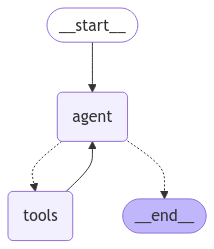

In [24]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
# inputs = {"messages": [("user", "삼성전자")]}
# for chunk in graph.stream(inputs, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

In [26]:
# inputs = {"messages": [("user", "네이버")]}
# for chunk in graph.stream(inputs, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

In [27]:
# inputs = {"messages": [("user", "SK하이닉스")]}
# for chunk in graph.stream(inputs, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

In [28]:
# inputs = {"messages": [("user", "SK텔레콤")]}
# #config = {"run_name": "SK텔레콤", "tags": ["valuation"]}
# for chunk in graph.stream(inputs, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

In [29]:
# inputs = {"messages": [("user", "크래프톤")]}
# for chunk in graph.stream(inputs, stream_mode="values"):
#     chunk["messages"][-1].pretty_print()

In [30]:
inputs = {"messages": [("user", "LG에너지솔루션")]}
for chunk in graph.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

LG에너지솔루션
================================== Ai Message ==================================
Tool Calls:
  find_price_tool (call_j3odcs27R4fkb3HH9Q4FaJP8)
 Call ID: call_j3odcs27R4fkb3HH9Q4FaJP8
  Args:
    company: LG에너지솔루션
  find_PER_tool (call_jOY4NRH7AO0DCPnOelO2vdJo)
 Call ID: call_jOY4NRH7AO0DCPnOelO2vdJo
  Args:
    company: LG에너지솔루션
  find_EPS_tool (call_YHeq4UukirkUhcJDkpvcM0M0)
 Call ID: call_YHeq4UukirkUhcJDkpvcM0M0
  Args:
    company: LG에너지솔루션
  find_PBR_tool (call_ekzW6v2EZWNHxB9EfYYTiD3U)
 Call ID: call_ekzW6v2EZWNHxB9EfYYTiD3U
  Args:
    company: LG에너지솔루션
  find_peer_PERs_tool (call_pa3FVGCKIrLhJMHKUhhBAd9c)
 Call ID: call_pa3FVGCKIrLhJMHKUhhBAd9c
  Args:
    company: LG에너지솔루션
  find_peer_PBRs_tool (call_4iBTahVQ58Lc1NKrAFzYmr7K)
 Call ID: call_4iBTahVQ58Lc1NKrAFzYmr7K
  Args:
    company: LG에너지솔루션


/var/folders/f7/84_7pkk50r10snsc2qr066600000gn/T/ipykernel_55738/2676639117.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  earning_ttm += ticker.quarterly_income_stmt.loc['Net Income Common Stockholders'][i]
/var/folders/f7/84_7pkk50r10snsc2qr066600000gn/T/ipykernel_55738/2676639117.py:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  earning_ttm += ticker.quarterly_income_stmt.loc['Net Income Common Stockholders'][i]
/var/folders/f7/84_7pkk50r10snsc2qr066600000gn/T/ipykernel_55738/2676639117.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys wil

================================= Tool Message =================================
Name: find_peer_PBRs_tool

{"Peer PBRs": {"삼성SDI": 0.8446342323998962, "Panasonic": 0.5601353443729374, "BYD": 2.8680111101714547, "Tesla": 13.648825505644133}, "Peer list": ["삼성SDI", "CATL", "Panasonic", "SK On", "BYD", "Tesla", "Northvolt"], "Average Peer PBR": 4.480401548147105}
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_results_json (call_fXxMCrCCT4KsHW54HHYwobfY)
 Call ID: call_fXxMCrCCT4KsHW54HHYwobfY
  Args:
    query: LG에너지솔루션 주요 사업부 매출 비중
  duckduckgo_results_json (call_DRPaKalrZ4B6RLRyb99M6CAS)
 Call ID: call_DRPaKalrZ4B6RLRyb99M6CAS
  Args:
    query: LG에너지솔루션 사업부 관련 뉴스
  duckduckgo_results_json (call_FaNEMsntOPYyi3KSlj90UgZT)
 Call ID: call_FaNEMsntOPYyi3KSlj90UgZT
  Args:
    query: 한국 경제 뉴스
  duckduckgo_results_json (call_IfzViOyTfkkQ3OeWyqfQqbnR)
 Call ID: call_IfzViOyTfkkQ3OeWyqfQqbnR
  Args:
    query: 정치 뉴스 한국 경제
=============